### Semi-dual formulation

We now have here the semi-dual formulation : 
$$
OT(\mathbf{a},\mathbf{b}) = \sup_{\alpha \in \mathbf{R}^m} \mathbf{\alpha}^{\top}a - OT^*(\mathbf{\alpha},\mathbf{b})
$$
Where $OT^*(\mathbf{\alpha},\mathbf{b}) = \sup\limits_{\mathbf{a} \in \Delta_m} \mathbf{a}^{\top} \alpha - OT(\mathbf{a},\mathbf{b})$.
The semi-dual formulation has a closed formulation, starting from the observation that :
$
OT^*(\mathbf{\alpha},\mathbf{b}) = \sum\limits_{j = 1}^{n} b_j \max_{\Omega_j}(\mathbf{\alpha} - \mathbf{c}_{\cdot,j})
$
, where $\Omega_j(y) = \frac{1}{b_j}\Omega(b_jy)$.
Eventually, the final optimization problem to solve is :
$
OT(\mathbf{a},\mathbf{b}) = \sup\limits_{\mathbf{\alpha} \in \mathbf{R}^m} \mathbf{a}^{\top} \alpha - \sum\limits_{j = 1}^{n} b_j \max_{\Omega_j}(\mathbf{\alpha} - \mathbf{c}_{\cdot,j})
$
In a similar way as before, the primal optimal is related to the dual optimal thanks to the relation : 
$
\mathbf{t}_j^* = b_j\nabla \max_{\Omega_j}(\alpha^* - \mathbf{c}_{\cdot,j})
$

In [3]:
import numpy as np
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy as sc
from scipy.sparse import csr_matrix, identity
import cvxpy as cp
import functions
gamma = 10

In [4]:
FNAME = 'drapeau.jpg'
img_ref = Image.open(FNAME).convert('RGB')
x = np.array(img_ref)
r_ref, g_ref, b_ref= np.rollaxis(x, axis = -1)
x_ref = np.dstack([r_ref, g_ref, b_ref])
img_ref = Image.fromarray(x_ref, 'RGB')

In [5]:
FNAME = 'arbre.jpg'
img_src = Image.open(FNAME).convert('RGB')
x = np.array(img_src)
r_src, g_src, b_src = np.rollaxis(x, axis = -1)
x_src = np.dstack([r_src, g_src, b_src])
img_src = Image.fromarray(x_src, 'RGB')

In [6]:
width_ref , length_ref,_= np.shape(x_ref)
width_src, length_src,_ = np.shape(x_src)

N_src = width_src*length_src
N_ref = width_ref*length_ref

In [7]:
file_path = 'semi_dual.txt'

with open(file_path) as file:
    line_list = file.readlines()
    line_list = [float(item.rstrip()) for item in line_list]

In [8]:
colors_ref = np.empty((width_ref*length_ref,3))
j = 0
for i in range(width_ref*length_ref):
    j = i%length_ref #number of column
    l = i//length_ref #number of row
    colors_ref[i,0] = r_ref[l,j]
    colors_ref[i,1] = g_ref[l,j]
    colors_ref[i,2] = b_ref[l,j] 

colors_src = np.empty((width_src*length_src,3))
j = 0
for i in range(width_src*length_src):
    j = i%length_src #width
    l = i//length_src
    colors_src[i,0] = r_src[l,j]
    colors_src[i,1] = g_src[l,j]
    colors_src[i,2] = b_src[l,j] 


Text(0.5, 0, 'N° clusters')

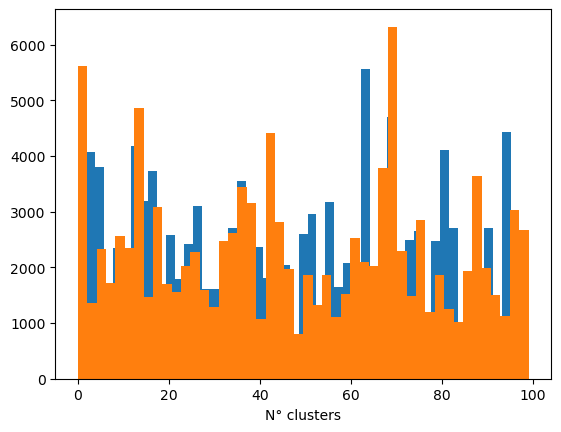

In [9]:
n_src, n_ref = 100, 100 #number of clusters
k_means_color_ref = KMeans(n_clusters = n_ref, random_state = 0, n_init = "auto").fit(colors_ref)
label_ref = k_means_color_ref.labels_
hist_ref = np.histogram(label_ref, bins = n_ref)
plt.hist(label_ref, bins = "auto")

k_means_color_src = KMeans(n_clusters = n_src, random_state = 0, n_init = "auto").fit(colors_src)
label_src = k_means_color_src.labels_
hist_src = np.histogram(label_src, bins = n_src)
plt.hist(label_src, bins = "auto")
plt.xlabel('N° clusters')

In [10]:
X = [i for i in range(10)]
a = [hist_ref[0][i]/N_ref for i in range(n_ref)]
b = [hist_src[0][i]/N_src for i in range(n_src)]

Building of matrix $(C_{i,j})_{i,j \in \llbracket 1,m\rrbracket \times \llbracket 1,n \rrbracket} = (d(\hat{\mathbf{x}}_i^{\text{ref}}, \hat{\mathbf{x}}_j^{\text{src}}))_{i,j \in \llbracket 1,m\rrbracket \times \llbracket 1,n \rrbracket}$ where $\hat{\mathbf{x}}_i^{\text{ref}}$ is the i-th centroid  of the reference image and $\hat{\mathbf{x}}_j^{\text{src}}$ is the j-th centroid of the source image.

In [11]:
def dist(x,y):
    """
    return euclidian distance between x and y
    Outputs : 
        ||x - y||^2
    """
    return np.dot(x,x) - 2*np.dot(x,y) + np.dot(y,y)

In [12]:
cluster_center_ref = k_means_color_ref.cluster_centers_/256
cluster_center_src = k_means_color_src.cluster_centers_/256

c = np.empty((n_ref*n_src))
for i in range(n_ref): #Nombre de lignes
    for j in range(n_src): #Nombre de colonnes"
        c[i + j * n_ref] = dist(cluster_center_src[j], cluster_center_ref[i])

In [13]:
###
def find(Y):
    """
    Returns the index sought for finding the root 

    Args : 
        Y : vector we want to project on the unitary simplex (list n x 1)
    """
    for i in range(1,len(Y)): #We start from the largest element
        if np.sum([Y[j] - Y[i] for j in range(i)]) - 1 >= 0:
            return i
    return -1

def root(Y):
    """
    Returns the root of h, i.e the optimal Lagrange multiplier of the kkt conditions
    """
    Y_p = np.sort(Y) #We sort elements from smaller to larger
    Y_p = np.flip(Y_p)
    i = find(Y_p)
    if i >= 0:
        return (np.sum(Y_p[:i]) - 1)/i
    else:
        return (np.sum(Y) - 1)/len(Y)
    
def max(a,b):
    if a<b: 
        return b
    return a

def proj_simplexe(Y): 
    mu = root(Y)
    if mu == 'non feasible':
        return Y
    else:
        return [max(Y[i] - mu, 0) for i in range(len(Y))]

def entropy(Y,gamma):
    return np.sum([Y[i]*np.log(Y[i])*gamma for i in range(len(Y))])

def conjug_entropy(x, gamma):
    return gamma*np.sum([np.exp(i/gamma - 1) for i in x])

def grad_conjug_entropy(x, gamma):
    return np.array([np.exp(i/gamma - 1) for i in x])

def max_entropy(x,gamma,b):
    return gamma*np.log(np.sum([np.exp(i/gamma) for i in x])) - np.log(b)*gamma

def grad_max_entropy(x, gamma):
    L = [np.exp(i/gamma) for i in x]
    return np.array(L/np.sum(L))
#----------------------------------------------------------------------------------------------
def squared_norm(x,gamma):
    return np.linalg.norm(x)**2 * gamma/2

def conjug_squared_norm(x,gamma):
    return 1/(2*gamma)*np.sum([x[i]**2 for i in range(len(x)) if x[i] > 0])

def grad_conjug_squared_norm(x,gamma):
    return np.maximum(x,0)/gamma

def grad_max_squared_norm(x,gamma,b):
    return np.array(proj_simplexe(x/(gamma*b)))

def max_squared_norm(x,gamma,b):
    y = grad_max_squared_norm(x,gamma, b)
    return np.dot(x,y) - gamma*b/2*np.dot(y,y)


In [208]:
gamma_L = [1e-3,1e-2,1e-1,1e0,1e1]
gamma = gamma_L[0]
Time_ent = [11.9, 5.8, 6.9, 20, 29.2] #in s
value_ent = [-0.04180771856471783, 0.01776160530403082, 0.736, 8.513380845659926, 86.9764363839297]

Time_l2 = [15.7, 9.4, 6, 7, 5.5]
value_l2 = [-0.047131930735265726, -0.047173068109763426, -0.04751422378084716, -0.049440365403945655, -0.05769053864874594]
def function_semi(x):
    """
    semi dual formulation function
    Args : 
        x : is alpha (int m)
    Ouputs : 
        the semi dual formulation evaluated at x
    """
    val = np.dot(a,x) - np.sum([b[i]*max_squared_norm(x - c[i*n_ref : ( i + 1 )*n_ref], gamma, b[i]) for i in range(n_src)])
    grad = a.copy()
    for i in range(n_src):
       grad -= b[i]*grad_max_squared_norm(x - c[i*n_ref : (i+1)*n_ref], gamma, b[i])

    t_sol_semi = np.empty((n_ref*n_src))
    for i in range(n_src):
        t_sol_semi[i*n_ref: (i + 1)*n_ref] = b[i]*grad_max_squared_norm(x - c[n_ref*i : n_ref*(i + 1)], gamma, b[i])
    return -val, -grad

In [209]:
x0 = np.zeros((n_ref))
res_semi = sc.optimize.minimize(function_semi, x0, method = 'BFGS', jac = True)

In [210]:
print(res_semi)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.047131930735265726
        x: [-1.069e-01  3.200e-02 ... -7.648e-02  7.577e-03]
      nit: 411
      jac: [-1.941e-06  1.324e-06 ... -4.641e-07 -2.289e-07]
 hess_inv: [[ 1.943e-02  5.578e-03 ...  9.166e-03  5.627e-03]
            [ 5.578e-03  1.612e-02 ...  8.466e-03  1.590e-02]
            ...
            [ 9.166e-03  8.466e-03 ...  1.885e-02  8.299e-03]
            [ 5.627e-03  1.590e-02 ...  8.299e-03  1.770e-02]]
     nfev: 625
     njev: 625


In [176]:
alpha_semi = res_semi.x
t_sol_semi = np.empty((n_ref*n_src))
for i in range(n_src):
    t_sol_semi[i*n_ref: (i + 1)*n_ref] = b[i]*grad_max_squared_norm(alpha_semi - c[n_ref*i : n_ref*(i + 1)], gamma, b[i])

In [177]:
def equality(m,n):
    """
    Build here all the equality constraints for regular OT
    Args : 
        m : number of constraints (i.e number of cluster colors) for reference image (int n_ref)
        n : number of constraints (i.e number of cluster colors) for source image (int n_ref)

    Output:
        Matrix for first set of constraints A1 and second set of constraints
    """
    A1 = np.zeros((m,n*m)) #equality for a
    A2 = np.zeros((n,n*m)) #equality for b

    for j in range(m):
        for i in range(0,n*m,m):
            A1[j, j + i] = 1
    k = 0
    for j in range(n):
        A2[j,k: k + m] = 1
        k += m
    return A1,A2


d = np.concatenate((a,b))
t = cp.Variable(n_ref*n_src)
A1,A2 = equality(n_ref,n_src)
A = np.concatenate((A1,A2))

In [178]:
def from_vector_to_tensor(t,m,n):
    """
    Transform a vector of size mn into a m times n tensor columnwise like it is done for t and c
    Args : 
        t : vector to transform
        m : number of cluster of reference image
        n : number of cluster of source image
    Output : 
    The square matrix equivalent to t in columnwise setting
    """
    T = np.empty((m,n))
    for i in range(m*n):
        j = i//m
        l = i%m
        T[l,j] = t[i]
    return T

def mean_vector(T,y,n_src,n_ref):
    """
    new color after transport of y with T
    Args:
        T : transport plan (list nm)
        y : cluster of the source (or reference) image (int)
        n_src : number of cluster of the source image (int)
        n_ref : number of cluster of the reference image (int)
    Outputs : 
        solution of the barycentric problem projection
    """
    x = np.empty((n_ref,3))
    for i in range(n_ref):
        t = 0
        for j in range(n_src):
            t += T[i + j*n_ref]*y[j]
        x[i] = t/np.sum([T[i + j*n_ref] for j in range(n_src)])
    return x

cluster_center_new_dual = mean_vector(t_sol_semi,cluster_center_src,n_src,n_ref)

In [179]:
image_n = cluster_center_new_dual[label_ref]

In [180]:
image_new = np.zeros((width_ref, length_ref, 3))
for i in range(width_ref):
    for j in range(length_ref):
        image_new[i,j] = image_n[i*length_ref + j] #row-wise

(-0.5, 399.5, 299.5, -0.5)

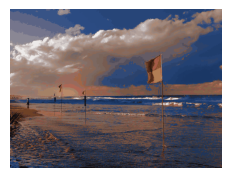

In [181]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(221)
ax.imshow(image_new)
ax.axis("off")

In [182]:
T_sol_semi = from_vector_to_tensor(t_sol_semi, n_src, n_ref)
sparsity = (n_ref*n_src - len(t_sol_semi[t_sol_semi > 0]))/(n_ref*n_src) #Percentage of sparsity
sparsity

0.9801

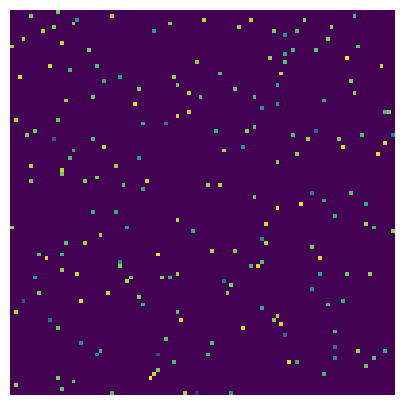

In [183]:
plt.figure(figsize=(5,5))
plt.imshow(np.log(T_sol_semi+1e-5))
plt.axis('off');

Solving regular OT to have $T^\star$ to compare with dual solutions.

In [184]:
d = np.concatenate((a,b))
t = cp.Variable(n_ref*n_src)
A1,A2 = equality(n_ref,n_src)
A = np.concatenate((A1,A2))

In [185]:
prob = cp.Problem(cp.Minimize(c.T@t),
                 [A @ t == d, t >= 0])
prob.solve(solver = 'ECOS')
# Print result.
print("\n The optimal value is", prob.value)
print("A solution t is")
print(t.value)


 The optimal value is 0.04712733932031491
A solution t is
[-7.76024682e-16  1.30526751e-14 -1.62347218e-17 ... -1.20668470e-15
 -1.23941721e-15 -8.42826227e-16]


In [199]:
Cons_error_ent = [0.00011688301972660293, 0.00012966141194892041, 0.00019817120335589514, 0.37512061523826823]
error_opt_ent = [0.049820104363966916, 0.08315017421874625, 0.09256207123345388, 0.09492907464627752]

Cons_error_n = [0.0001302790485661574, 0.00011131763758070159, 0.00012794422016657094, 0.00010912568978732305, 0.00012568596842583936]
error_opt_n = [2.2683217817656628e-05, 0.003933000254795378, 0.03714621299852591, 0.06750391124843953, 0.08408442385354718]

def ent(a):
    entropy = 0
    for i in a:
        entropy += -i*np.log(i)
    return entropy

ent_a = ent(a)
ent_b = ent(b)
#For entropy regularization
L_e = np.dot((ent_a + ent_b), gamma_L)
U_e = np.dot(max(ent_a,ent_b),gamma_L)

#For squared-norm regularization
L_n = np.dot(1/2*np.sum([(a[i]/n_src + b[j]/n_ref - 1/(n_src*n_ref))**2 for i in range(len(a)) for j in range(len(b))]),gamma_L)
U_n = np.dot((np.min((np.linalg.norm(a)**2, np.linalg.norm(b)**2))),gamma_L)

value_ent = [0.04180771856471783, -0.01776160530403082, -0.736, -8.513380845659926, -86.9764363839297]
value_l2 = [0.047131930735265726, 0.047173068109763426, 0.04751422378084716, 0.049440365403945655, 0.05769053864874594]

value_error_ent = np.abs(value_ent - prob.value)
value_error_l2 = value_l2 - prob.value

In [200]:
value_error_ent

array([5.31962076e-03, 6.48889446e-02, 7.83127339e-01, 8.56050818e+00,
       8.70235637e+01])

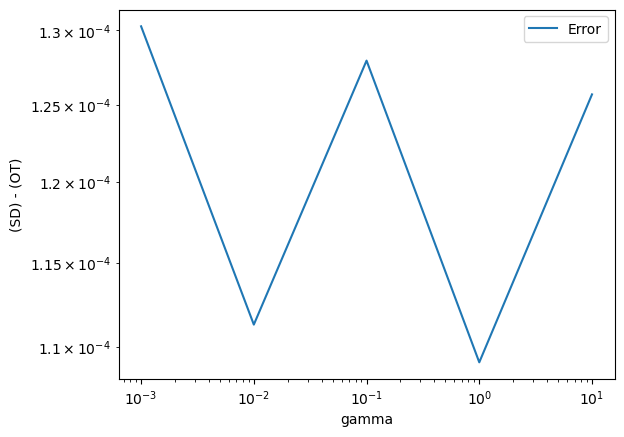

In [207]:
plt.loglog(gamma_L,Cons_error_n, label = 'Error')
plt.xlabel('gamma')
plt.ylabel('(SD) - (OT)')
plt.legend()

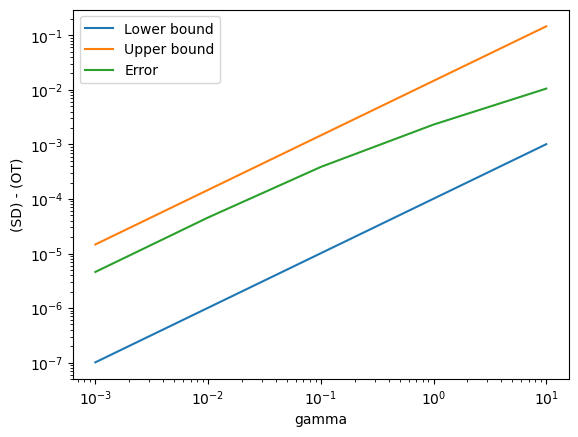

In [212]:
plt.loglog(gamma_L,L_n, label = 'Lower bound')
plt.loglog(gamma_L,U_n, label = 'Upper bound')
plt.loglog(gamma_L,value_error_l2, label = 'Error')
plt.xlabel('gamma')
plt.ylabel('(SD) - (OT)')
plt.legend()

In [ ]:
plt.loglog(gamma_L,U_e, label = 'Lower bound')
plt.loglog(gamma_L,L_e, label = 'Upper bound')
plt.loglog(gamma_L,value_error_ent, label = 'Error')
plt.xlabel('gamma')
plt.ylabel('(SD) - (OT)')
plt.legend()

Evolution of error $||T_{semi-dual} - T^\star||$

In [ ]:
file_path = 'semi_dual.txt'

with open(file_path) as file:
    line_list = file.readlines()
    line_list = [float(item.rstrip()) for item in line_list]

file_path = 'semi_dual_ent.txt'

with open(file_path) as file:
    line_list_ent = file.readlines()
    line_list_ent = [float(item.rstrip()) for item in line_list_ent]

Text(0, 0.5, 'Error to optimal transport T*')

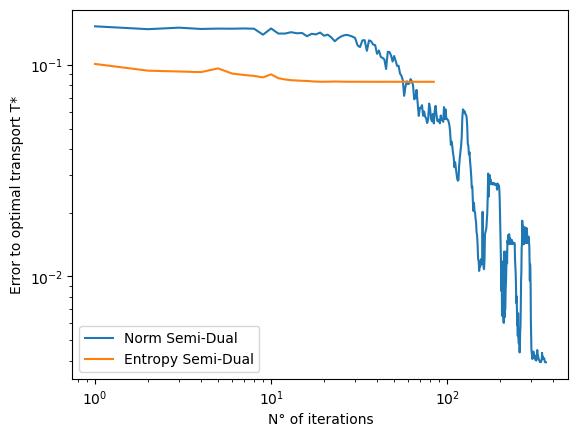

In [ ]:
n_iter_n = 364
N = np.linspace(1,n_iter_n,n_iter_n)
plt.loglog(N,line_list, label = 'Norm Semi-Dual')

n_iter_ent = 84
N_ent = np.linspace(1,n_iter_ent,n_iter_ent)
plt.loglog(N_ent,line_list_ent, label = 'Entropy Semi-Dual')

plt.legend()

plt.xlabel('N° of iterations')
plt.ylabel('Error to optimal transport T*')